<br></br>
<h1><center>Assignment 05</h1></center>
<h1><center>Logistic regression</h1></center>
<h2><center>Benedek Dankó</h2></center>

In [177]:
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
import statsmodels.discrete.discrete_model as sm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


#### 1. Download data from https://science.sciencemag.org/content/359/6378/926 (supplementary materials). If you do not succeed, you will find _aar3247_Cohen_SM_Tables-S1-S11.xlsx_ file in the homework's folder.

In [178]:
# read data, drop unnecessary columns:
df = pd.read_excel('../data/aar3247_Cohen_SM_Tables-S1-S11.xlsx', sheet_name='Table S6', header=2,
                  nrows=1817)

# create list storing whether sample is cancerous (1) or not (0)
df['CancerSEEK Test Result'][df['CancerSEEK Test Result'] == 'Positive'] = 1
df['CancerSEEK Test Result'][df['CancerSEEK Test Result'] == 'Negative'] = 0

cseekY = df['CancerSEEK Test Result'].to_list() # predicted by CancerSEEK
cseek_score = df['CancerSEEK Logistic Regression Score'].to_list() # CancerSEEK model pred. probabilities
trueY = [0 if i != 'Normal' else 1 for i in df['Tumor type'].to_list()] # true Y label, converted to binary

df.drop(['CancerSEEK Test Result', 'CancerSEEK Logistic Regression Score', # drop unnecessary columns
        'AJCC Stage', 'Patient ID #'], axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [179]:
# remove "*" from columns having it, convert it to float type if possible:
for col in list(df):
    try:
        if df[col].str.contains('\*').any() == True:
            print("{} has asterisk".format(col))
            df[col] = df[col].map(lambda x: str(x).lstrip('*').rstrip('*')).astype(float)
    except:
        print("Can't convert {} - string column".format(col))

AFP (pg/ml) has asterisk
Angiopoietin-2 (pg/ml) has asterisk
Can't convert AXL (pg/ml) - string column
CA-125 (U/ml) has asterisk
CA 15-3 (U/ml) has asterisk
CA19-9 (U/ml) has asterisk
CD44 (ng/ml) has asterisk
CEA (pg/ml) has asterisk
CYFRA 21-1 (pg/ml) has asterisk
DKK1 (ng/ml) has asterisk
Endoglin (pg/ml) has asterisk
FGF2 (pg/ml) has asterisk
Follistatin (pg/ml) has asterisk
Galectin-3 (ng/ml) has asterisk
G-CSF (pg/ml) has asterisk
GDF15 (ng/ml) has asterisk
HE4 (pg/ml) has asterisk
HGF (pg/ml) has asterisk
IL-6 (pg/ml) has asterisk
IL-8 (pg/ml) has asterisk
Kallikrein-6 (pg/ml) has asterisk
Leptin (pg/ml) has asterisk
Mesothelin (ng/ml) has asterisk
Midkine (pg/ml) has asterisk
Myeloperoxidase (ng/ml) has asterisk
NSE (ng/ml) has asterisk
OPG (ng/ml) has asterisk
OPN (pg/ml) has asterisk
PAR (pg/ml) has asterisk
Prolactin (pg/ml) has asterisk
sEGFR (pg/ml) has asterisk
sFas (pg/ml) has asterisk
SHBG (nM) has asterisk
sHER2/sEGFR2/sErbB2 (pg/ml) has asterisk
Can't convert sPECAM-

In [180]:
# check column types:
g = df.columns.to_series().groupby(df.dtypes).groups
print(g)

{dtype('float64'): Index(['AFP (pg/ml)', 'Angiopoietin-2 (pg/ml)', 'AXL (pg/ml)', 'CA-125 (U/ml)',
       'CA 15-3 (U/ml)', 'CA19-9 (U/ml)', 'CD44 (ng/ml)', 'CEA (pg/ml)',
       'CYFRA 21-1 (pg/ml)', 'DKK1 (ng/ml)', 'Endoglin (pg/ml)',
       'FGF2 (pg/ml)', 'Follistatin (pg/ml)', 'Galectin-3 (ng/ml)',
       'G-CSF (pg/ml)', 'GDF15 (ng/ml)', 'HE4 (pg/ml)', 'HGF (pg/ml)',
       'IL-6 (pg/ml)', 'IL-8 (pg/ml)', 'Kallikrein-6 (pg/ml)',
       'Leptin (pg/ml)', 'Mesothelin (ng/ml)', 'Midkine (pg/ml)',
       'Myeloperoxidase (ng/ml)', 'NSE (ng/ml)', 'OPG (ng/ml)', 'OPN (pg/ml)',
       'PAR (pg/ml)', 'Prolactin (pg/ml)', 'sEGFR (pg/ml)', 'sFas (pg/ml)',
       'SHBG (nM)', 'sHER2/sEGFR2/sErbB2 (pg/ml)', 'sPECAM-1 (pg/ml)',
       'TGFa (pg/ml)', 'Thrombospondin-2 (pg/ml)', 'TIMP-1 (pg/ml)',
       'TIMP-2 (pg/ml)'],
      dtype='object'), dtype('O'): Index(['Sample ID #', 'Tumor type'], dtype='object')}


In [181]:
df.describe()

,AFP (pg/ml),Angiopoietin-2 (pg/ml),AXL (pg/ml),CA-125 (U/ml),CA 15-3 (U/ml),CA19-9 (U/ml),CD44 (ng/ml),CEA (pg/ml),CYFRA 21-1 (pg/ml),DKK1 (ng/ml),...,Prolactin (pg/ml),sEGFR (pg/ml),sFas (pg/ml),SHBG (nM),sHER2/sEGFR2/sErbB2 (pg/ml),sPECAM-1 (pg/ml),TGFa (pg/ml),Thrombospondin-2 (pg/ml),TIMP-1 (pg/ml),TIMP-2 (pg/ml)
count,1817.000000,1817.000000,1811.000000,1817.000000,1817.000000,1817.000000,1811.000000,1817.000000,1.817000e+03,1817.000000,...,1817.000000,1811.000000,1816.000000,1817.000000,1811.000000,1811.000000,1817.000000,1811.000000,1817.000000,1817.000000
mean,7109.350915,1908.423015,2367.282468,25.183043,20.628611,53.828772,19.533026,4427.203445,4.843461e+03,1.050809,...,32313.975855,2206.283738,1390.840456,67.922256,5765.088272,5883.915544,28.108763,5502.450456,70058.422889,40261.117001
std,52353.921638,1814.768306,1369.702573,184.585378,64.345361,409.030952,11.341536,23696.803234,4.238234e+04,0.442416,...,54139.458378,1214.316206,2354.800543,54.478992,4376.221802,2174.283827,283.264077,10204.121339,47577.490820,12970.481941
min,706.158000,38.391000,109.440000,4.608000,1.320000,14.214000,6.750000,426.438000,1.816458e+03,0.350000,...,806.280000,197.580000,192.948000,1.500000,306.280000,219.830000,15.258000,482.140000,976.550000,15026.320000
25%,829.980000,997.490000,1479.425000,4.890000,7.110000,16.320000,11.960000,614.200000,1.955244e+03,0.740000,...,8617.160000,1323.520000,206.334000,31.430000,4228.430000,4384.605000,16.200000,1145.100000,41231.360000,30752.350000
50%,946.938000,1498.920000,2136.610000,4.980000,12.180000,16.482000,16.760000,1045.440000,1.994874e+03,0.940000,...,14032.920000,2052.170000,1126.515000,53.350000,5261.220000,5499.780000,16.488000,2245.650000,59282.780000,37735.410000
75%,1848.540000,2259.460000,2931.680000,6.400000,19.840000,18.600000,23.795000,1924.610000,2.106970e+03,1.250000,...,26552.970000,2906.490000,1803.705000,87.350000,6470.335000,7023.805000,16.698000,5673.605000,82928.930000,46794.540000
max,600608.892000,30001.791000,12247.310000,3600.024000,1177.446000,12491.472000,148.440000,337245.426000,1.475728e+06,5.970000,...,608432.382000,8576.920000,61146.100000,478.840000,150848.100000,20178.170000,12018.864000,157461.070000,569512.690000,105748.640000


#### 2. Predict if a sample is cancerous or not

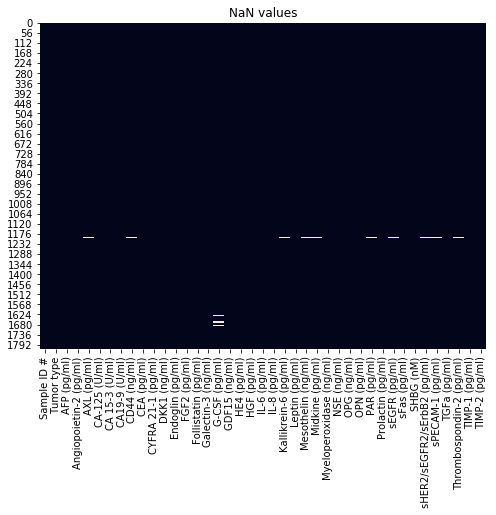

In [182]:
# Plot nan values:
plt.figure(figsize=(8, 6))
plt.title('NaN values')
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [183]:
# fill up NaNs with column means:
df.fillna(df.mean(), inplace=True)

In [184]:
# split dataset:
trainX = df.drop(['Tumor type', 'Sample ID #'], axis=1).values[::2] # keep only numeric columns (protein levels)
trainY = trueY[::2]
testX  = df.drop(['Tumor type', 'Sample ID #'], axis=1).values[1::2]
testY = trueY[1::2]

In [185]:
# fit model:
model = LogisticRegression(random_state=11).fit(trainX, trainY)

In [186]:
# accuracy score:
acc = model.score(testX, testY)
print(acc)

0.8579295154185022


In [187]:
# preditction: 
predicted = model.predict(testX)
print('First 10 predicted y: {}'.format(predicted[:10]))
print('First 10 y test points: {}'.format(testY[:10]))

First 10 predicted y: [0 0 0 0 0 1 0 0 0 0]
First 10 y test points: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


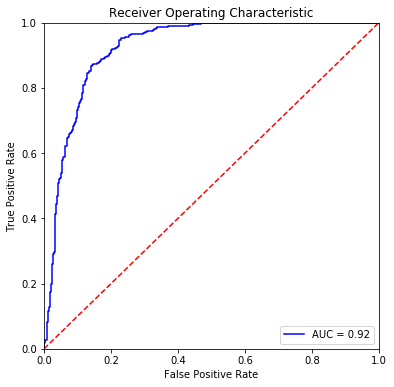

In [188]:
# calculate the fpr and tpr for all thresholds of the classification
# idea from here: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

probs = model.predict_proba(testX)
preds = probs[:,1] # probability values for the logistic regression
fpr, tpr, threshold = metrics.roc_curve(testY, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

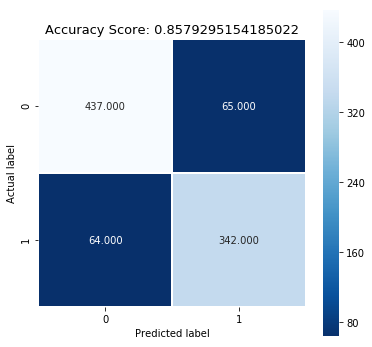

In [189]:
# Confusion matrix:
cm = metrics.confusion_matrix(testY, predicted)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Accuracy Score: {0}'.format(acc), size = 13)
plt.show()

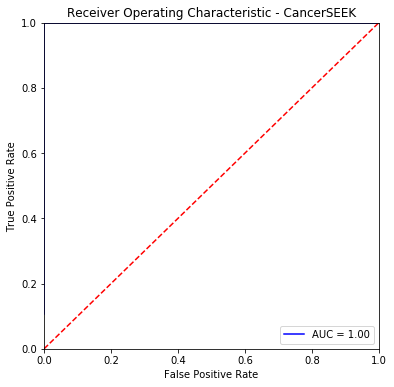

In [190]:
# CancerSEEK ROC curve:
fpr, tpr, threshold = metrics.roc_curve(cseekY[1::2], cseek_score[1::2], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic - CancerSEEK')
plt.plot(fpr, tpr, 'b-', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

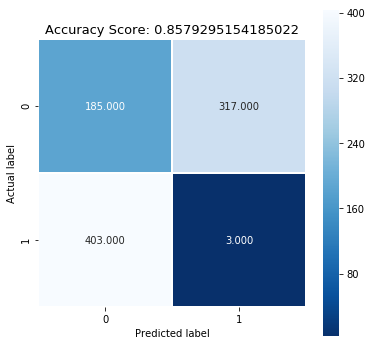

In [191]:
# Confusion matrix:
cm = metrics.confusion_matrix(testY, cseekY[1::2])
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Accuracy Score: {0}'.format(acc), size = 13)
plt.show()

Their model is great, having AUC 1.0. <br>
My model's performance is below the CancserSEEK's, with 0.92 AUC. <br> However, the confusion matrix is exactly the same, with the same accuracy. <br><br>
It seems, that the CancerSEEk method used a different threshold for the logistic regression, which is around 0.9. Over 0.9 probability predictions were classified as Positive (cancer), and below 0.9 as Negative. In my case, the basic threshold is 0.5. This is the reason of having different ROC plots.

#### 4. Hepatocellular carcinoma

In [192]:
# filter rows, we need ros with tumor type Liver, or Normal
df_hep = df.loc[(df['Tumor type'] == 'Normal') | (df['Tumor type'] == 'Liver')]

In [193]:
features = list(df_hep)
features = features[2:27] # first 25 protein level features

In [194]:
# train X, train Y data:
trainX = df_hep[features]
trainY = [1 if i == 'Liver' else 0 for i in df_hep['Tumor type'].to_list()]

In [195]:
# Logistic regression model, fit data:
log_reg = sm.Logit(np.asarray(trainY), np.asarray(trainX)).fit()

Optimization terminated successfully.
         Current function value: 0.030425
         Iterations 12


In [196]:
# printing the summary table 
print(log_reg.summary()) 

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  856
Model:                          Logit   Df Residuals:                      831
Method:                           MLE   Df Model:                           24
Date:                Wed, 07 Oct 2020   Pseudo R-squ.:                  0.8498
Time:                        14:09:48   Log-Likelihood:                -26.044
converged:                       True   LL-Null:                       -173.44
                                        LLR p-value:                 1.864e-48
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          3.091e-05   1.11e-05      2.773      0.006    9.06e-06    5.28e-05
x2            -0.0003      0.000     -1.163      0.245      -0.001       0.000
x3             0.0005      0.001      0.945      0.3

The 5 best predictor based on P values:
- HGF (x18, p = 0.000)
- HE4 (x17, p = 0.001)
- DKK1 (x10, p = 0.001)
- AFP (x1, p = 0.006)
- CD44 (x7, p = 0.008)

According to [this](https://www.hindawi.com/journals/ijh/2012/859076/) paper, the most common HCC bimoarkers are:
- AFP
- GPC3
- DCP
- GGT
- AFU
- HCR2
- GOLPH2
- TGF-Beta 
- TSGF
- EGFR family 
- HGF/SF
- FGF

Out of these 12 biomarkers, our model predicted 2 also as a factor associated with HCC.

#### 5. Multiclass classification

In [197]:
# training X:
trainX = df.drop(['Tumor type', 'Sample ID #'], axis=1).values[::2]

In [198]:
tumor_types = list(set(df['Tumor type'].to_list())) # 8 tumor types

Y = [] # converted to numeric (0-8)
for i in df['Tumor type'].to_list():
    Y.append(tumor_types.index(i))

In [199]:
trainY = Y[::2] # each 2nd value

In [200]:
# fit model:
model2 = LogisticRegression(multi_class='multinomial', solver ='newton-cg', 
                            random_state=11).fit(trainX, trainY)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [201]:
# test data:
testX = df.drop(['Tumor type', 'Sample ID #'], axis=1).values[1::2]
testY = Y[1::2]

In [202]:
# accuracy score:
acc = model2.score(testX, testY)
print(acc)

0.6420704845814978


In [203]:
# preditction: 
predicted = model2.predict(testX)
print('First 10 predicted y: {}'.format(predicted[:10]))
print('First 10 y test points: {}'.format(testY[:10]))
print('\n')
print('Last 10 predicted y: {}'.format(predicted[-10:]))
print('Last 10 y test points: {}'.format(testY[-10:]))

First 10 predicted y: [7 0 0 7 0 5 7 5 0 5]
First 10 y test points: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Last 10 predicted y: [2 7 0 2 2 2 2 2 0 7]
Last 10 y test points: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [204]:
same = 0
for i in range(len(predicted)):
    if predicted[i] == testY[i]:
        same += 1
print('predicted = Y true in {}% of the cases.'.format(same/len(testY)*100))
# btw same as model.score()

predicted = Y true in 64.20704845814979% of the cases.


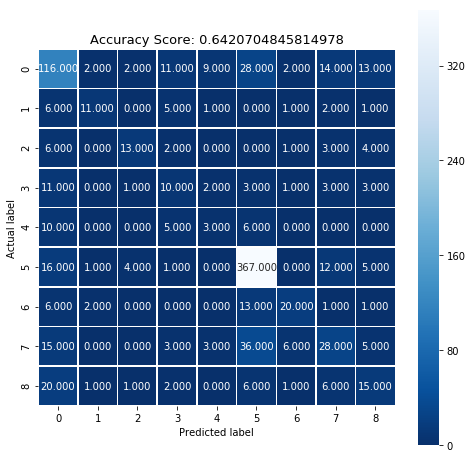

In [205]:
# Confusion matrix:
cm = metrics.confusion_matrix(testY, predicted)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Accuracy Score: {0}'.format(acc), size = 13)
plt.show()

It can be confusing that the classes don't have nearly the same number of rows - label 5 has much more rows in total.

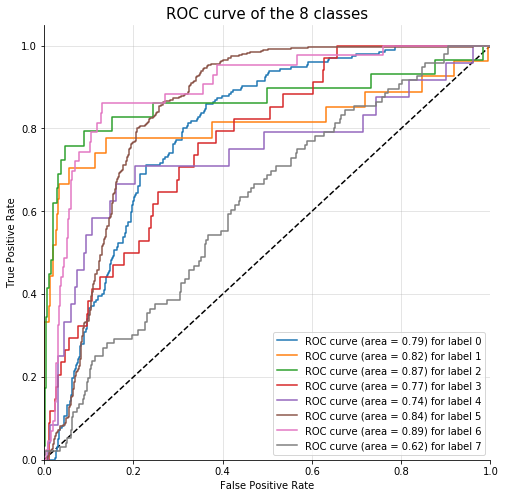

In [206]:
# Idea from here: https://stackoverflow.com/questions/45332410/sklearn-roc-for-multiclass-classification

# plot 8 ROC curves for the predicted classes on the same plot:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve of the 8 classes', size=15)
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(model2, testX, testY, n_classes=8, figsize=(8, 8))

In [207]:
tumor_types # where label 0 = Colorectal cancer, label 1 = Liver and so on

['Colorectum',
 'Liver',
 'Ovary',
 'Stomach',
 'Esophagus',
 'Normal',
 'Pancreas',
 'Breast',
 'Lung']

Based on the ROC curves, breast cancer, ovary cancer, and then pancreas, liver cancer can be predicted the most reliably using this multinomial logistic regression model.